In [3]:
import numpy as np
def relu_function(x):
    return np.maximum(0,x)

x = np.array([-1,1,2])
relu_function(x)

array([0, 1, 2])

Populating the interactive namespace from numpy and matplotlib


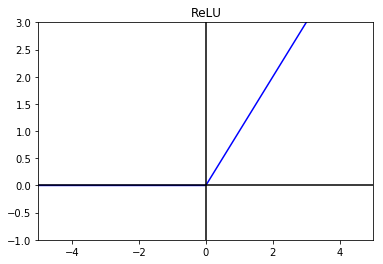

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, relu_function(z), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("ReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
x = np.array([-1,1,2])
leaky_relu(x)

array([-0.01,  1.  ,  2.  ])

Populating the interactive namespace from numpy and matplotlib


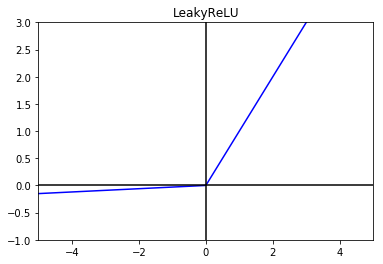

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, leaky_relu(z, 0.03), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("LeakyReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

## 使用GAN 產生手寫辨識數據

In [7]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np

C:\ProgramData\Anaconda3_2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def build_discriminator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [10]:
?Adam

In [11]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [12]:
latent_dim = 100
def build_generator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [13]:
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
__________

In [14]:
z = Input(shape=(latent_dim,))
img = generator(z)

In [15]:
discriminator.trainable = False

In [16]:
validity = discriminator(img)

In [17]:
validity 

<tf.Tensor 'model_2/sequential_2/dense_6/Sigmoid:0' shape=(?, 1) dtype=float32>

In [19]:
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [20]:
import os 
os.mkdir('images')

In [21]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # 正规化图片尺度至0  -  1的范围
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [ ]:
batch_size=32
sample_interval=200
epochs = 5000

(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):


    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)


    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch % sample_interval == 0:
        sample_images(epoch)

## DCGAN

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

### 讀取圖片數據

In [24]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator

### 建立生成器

In [25]:
def build_generator():

    model = Sequential()

    model.add(Dense(units=4 * 4 * 512,
                        input_shape=(1, 1, 100)))
    model.add(Reshape(target_shape=(4, 4, 512)))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=None)

    return model

### 建立鑑別器

In [26]:
def build_discriminator():

    model = Sequential()
    
    image_shape = (64, 64, 3)
    model.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             input_shape=(image_shape)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return model

### 圖片取樣

In [27]:
def sample_images(generated_images, epoch):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(generated_images.shape[0]):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'images/generatedSamples_epoch' + str(
        epoch + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()

### 建構生成器

In [28]:
# 建立生成器
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

In [29]:
## 建立鉴别器
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
__________

In [30]:
gan = Sequential()

discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

optimizer = Adam(lr=0.00015, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)

### 讀取明星圖片

In [45]:
dataset_path = 'idols/'
batch_size   =  64
image_shape  = (64, 64, 3)

dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

Found 211 images belonging to 1 classes.


In [46]:
number_of_batches  = int(dataset_generator.samples / batch_size)
adversarial_loss   = np.empty(shape=1)
discriminator_loss = np.empty(shape=1)
epochs = 250

In [48]:
import os
os.mkdir('models')

In [ ]:
for epoch in range(epochs):
    print("Epoch {} / {}:".format(epoch+1, epochs))

    for batch_number in range(number_of_batches):
        # 取得一批图片数据
        real_images = dataset_generator.next()
        # 将图片标准化至-1到1
        real_images = real_images / 127.5 - 1.

        # 每批大小不同，需每次计算该批数据量
        current_batch_size = real_images.shape[0]

        # 产生噪音
        noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, 100))

        # 使用生成器生成图片
        generated_images = generator.predict(noise)

        # 增加噪音扰乱鉴别器
        real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
        fake_y = np.random.random_sample(current_batch_size) * 0.2

        # 训练鉴别器
        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(real_images, real_y)
        d_loss += discriminator.train_on_batch(generated_images, fake_y)

        discriminator_loss = np.append(discriminator_loss, d_loss)

        # 训练生成器
        discriminator.trainable = False

        noise = np.random.normal(0, 1,size=(current_batch_size * 2,) +(1, 1, 100))

        # 给予反向标签以误导鉴别器
        fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

        g_loss = gan.train_on_batch(noise, fake_y)
        adversarial_loss = np.append(adversarial_loss, g_loss)
    

        # 打印损失
        print(" generator loss {} | discriminator loss {} ".format(g_loss, d_loss))


    # 存储模型与生成图片
    if (epoch + 1) % 5 == 0:
        discriminator.trainable = True
        generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
        discriminator.save('models/discriminator_epoch' +str(epoch) + '.hdf5')
        
        sample_images(generated_images, epoch)

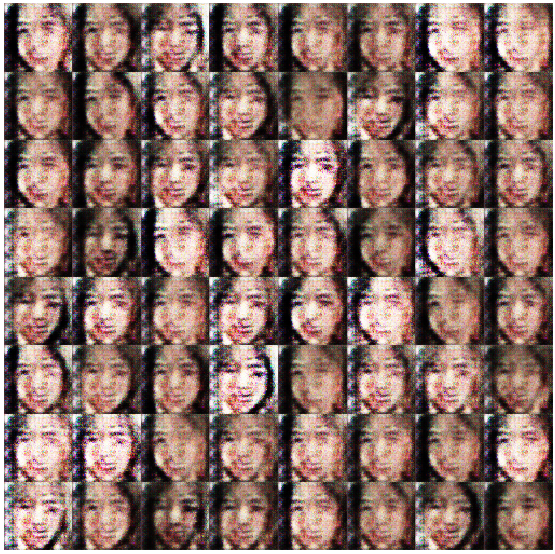

In [51]:
from PIL import Image
Image.open('images/generatedSamples_epoch245.png')

## CycleGAN

In [54]:
! pip install keras-contrib-master.zip

Processing c:\users\user\keras-contrib-master.zip
  Running setup.py bdist_wheel for keras-contrib: started
  Running setup.py bdist_wheel for keras-contrib: finished with status 'done'
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\6f\ef\1d\cb43a8a5b5ce8a8bff80337c66b04ae55137f8b4b0324bdf91
Successfully built keras-contrib


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Horse2Zebra dataset
- https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

In [55]:
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))
        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [56]:
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

In [57]:
# 用U-NET网路结构
def build_generator():

    # 下采样（Down Sampling）
    def conv2d(layer_input, filters, f_size=4):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d
    
    # 上采样（Upsampling）
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    #  输入图片
    d0 = Input(shape=img_shape)

    # 下采样
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)

    # 上采样和跨层连结
    u1 = deconv2d(d4, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

In [58]:
def build_discriminator():

    # 建立鉴别器网路层
    def d_layer(layer_input, filters, f_size=4, normalization=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d

    img = Input(shape=img_shape)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [59]:
def train(epochs, batch_size=1, sample_interval=50):

    start_time = datetime.datetime.now()

    # 真的图片的答案判定为1生成图片判定为0
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)

    for epoch in range(epochs):
        for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):

            #  训练鉴别器
            
            # 将图片从A翻译到B再从B翻译到A
            fake_B = g_AB.predict(imgs_A)
            fake_A = g_BA.predict(imgs_B)

            # 训练A鉴别器
            dA_loss_real = d_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = d_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

            # 训练B鉴别器
            dB_loss_real = d_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = d_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # 总鉴别器损失
            d_loss = 0.5 * np.add(dA_loss, dB_loss)


            #  训练生成器
            g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                                    [valid, valid,
                                                    imgs_A, imgs_B,
                                                    imgs_A, imgs_B])

            # 计算训练时间
            elapsed_time = datetime.datetime.now() - start_time

            # 打印进度
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                    % ( epoch, epochs,
                                                                        batch_i, data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        np.mean(g_loss[1:3]),
                                                                        np.mean(g_loss[3:5]),
                                                                        np.mean(g_loss[5:6]),
                                                                        elapsed_time))

            # 每sample_interval回合采样图片
            if batch_i % sample_interval == 0:
                sample_images(epoch, batch_i)

In [60]:
def sample_images(epoch, batch_i):
    os.makedirs('images/%s' % dataset_name, exist_ok=True)
    r, c = 2, 3

    imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

    # 将图片从A转译到B
    fake_B = g_AB.predict(imgs_A)
    
    # 将图片从B转译到A
    fake_A = g_BA.predict(imgs_B)
    
    # 重建图片（从B转译回A）
    reconstr_A = g_BA.predict(fake_B)
    
    # 重建图片（从A转译回B）
    reconstr_B = g_AB.predict(fake_A)

    # 生成图片
    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # 将图片标准化到0  -  1之间的范围
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%s/%d_%d.png" % (dataset_name, epoch, batch_i))
    plt.close()

In [61]:
# 图片参数
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

In [65]:
# 读取数据
dataset_name = 'horse2zebra'
data_loader = DataLoader(dataset_name=dataset_name, img_res=(img_rows, img_cols))


# 计算D输出的维度(PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# 生成器与鉴别器第一层的神经元数
gf = 32
df = 64

# 损失
lambda_cycle = 10.0               # 循环一致性损失
lambda_id = 0.1 * lambda_cycle    # Identity loss

optimizer = Adam(0.0002, 0.5)

# 建立以及编译鉴别器
d_A = build_discriminator()
d_B = build_discriminator()
d_A.compile(loss='mse',
    optimizer=optimizer,
    metrics=['accuracy'])
d_B.compile(loss='mse',
    optimizer=optimizer,
    metrics=['accuracy'])

In [66]:
# 建立生成器
g_AB = build_generator()
g_BA = build_generator()

# 从A B两个Domain输入图片
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# 从Domain A 将图片转译到 Domain B
fake_B = g_AB(img_A)

# 从Domain B 将图片转译到 Domain A
fake_A = g_BA(img_B)

# 从Domain B 将图片转译回 Domain A (重建)
reconstr_A = g_BA(fake_B)

# 从Domain A 将图片转译回 Domain B (重建)
reconstr_B = g_AB(fake_A)

# 建立图片识别ID
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# 只训练生成器
d_A.trainable = False
d_B.trainable = False

# 利用鉴别器辨别图片真伪
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# 训练生成器骗过鉴别器
combined = Model(inputs=[img_A, img_B],
                      outputs=[ valid_A, valid_B,
                                reconstr_A, reconstr_B,
                                img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse',
                       'mae', 'mae',
                       'mae', 'mae'],
                    loss_weights=[  1, 1,
                                    lambda_cycle, lambda_cycle,
                                    lambda_id, lambda_id ],
                    optimizer=optimizer)

In [ ]:
train(epochs=20, batch_size=10, sample_interval=10)

## Deep Convolution Q Network
- https://github.com/yenchenlin/DeepLearningFlappyBird

In [77]:
! pip install pygame

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [86]:
import argparse
import skimage as skimage
from skimage import transform, color, exposure
from skimage.transform import rotate
from skimage.viewer import ImageViewer
import sys

sys.path.append("game")
import wrapped_flappy_bird as game
import random
import numpy as np
from collections import deque

import json
from keras.initializers import normal, identity
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

In [87]:
GAME    = 'bird'             # 游戏Log名称
ACTIONS = 2                  # 动作种类 (0: Not Flap, 1: Flap)
GAMMA   = 0.99               # 动作衰退 decay
OBSERVATION       = 3200.    # 训练前观察的步骤
EXPLORE          = 3000000.  # 逐渐降低episilon的总步数
FINAL_EPSILON    = 0.0001    # epsilon最后的值
INITIAL_EPSILON  = 0.1       # epsilon的初始值
REPLAY_MEMORY    = 50000     # Replay 记忆最大长度
BATCH            = 32        # mini-batch的大小
FRAME_PER_ACTION = 1         # 每个动作对应到的帧 (Frame)
LEARNING_RATE    = 1e-4      # 学习率

img_rows , img_cols = 80, 80 # 输入图片大小

img_channels = 4             # 帧数量

In [88]:
def trainNetwork(model,args):
    # 起始游戏
    game_state = game.GameState()

    # 将过去的观察记忆在经验回放纪录（Experience Replay）D中
    D = deque()

    #  什么都不做取得第一个状态并开始预处理80X80X4大小的图
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    """
    r_0 代表 reward
    r_0 分为三种：
    0.1 : 代表bird活着
    +1  : 代表bird通过了水管
    -1  : 代表bird死亡
    
    terminal是个布尔标志用来判断游戏结束与否
    
    """
    
    # 图像预处理
    """
    将彩色图像转换为灰阶图
    调整图像的大小为80 X 80像素
    提供4张图像给神经网络进行训练
    """
    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    
    
    x_t = x_t / 255.0

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)

    #调整成Keras能吃的数据格式
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4

    

    if args['mode'] == 'Run':
        OBSERVE = 999999999    #只观测，不训练
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #进入训练模式
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        # 采用epsilon greedy当成动作
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                # 随机动作
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #输入四张图以取得预测结果
                # 采取最大Q值动作
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        # 渐渐降低epsilon
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        # 执行动作并且观测出状态与奖励
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        """
        r_t 代表 reward
        r_t 分为三种：
        0.1 : 代表bird活著
        +1  : 代表bird通过了水管
        -1  : 代表bird死亡
        """

        # 图像预处理
        """
        将彩色图像转换为灰阶图
        调整图像的大小为80 X 80像素
        提供4张图像给神经网络进行训练
        """
        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))


        x_t1 = x_t1 / 255.0


        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # 所有的episode(s,a,r,s′)都会存储在重放表格d中
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #结束观测后只单纯训练

        if t > OBSERVE:
            # 采样mini-batch做资料训练
            minibatch = random.sample(D, BATCH)

            # 经验回放 (Exprience Replay) 
            state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch) # (s,a,r,s′)
            state_t = np.concatenate(state_t)
            state_t1 = np.concatenate(state_t1)
            targets = model.predict(state_t)
            Q_sa = model.predict(state_t1)
            targets[range(BATCH), action_t] = reward_t + GAMMA*np.max(Q_sa, axis=1)*np.invert(terminal)

            loss += model.train_on_batch(state_t, targets)

        s_t = s_t1
        t = t + 1

        #每一千次存储模型
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # 印出相关资讯
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [89]:
def buildmodel():
    model = Sequential()
    #80*80*4 => 20*20*32 
    model.add(Convolution2D(32, 8, 8, subsample=(4, 4), border_mode='same',input_shape=(img_rows,img_cols,img_channels)))  
    model.add(Activation('relu'))
    #20*20*32 => 10*10*64
    model.add(Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    #10*10*64 => 10*10*64
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    # 10*10*64 => 6400
    model.add(Flatten())
    # 6400 => 512
    model.add(Dense(512))
    model.add(Activation('relu'))
    # 512 => 2
    model.add(Dense(2))
    
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    model.summary()
    return model

In [90]:

buildmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_15 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 10, 10, 64)        32832     
_________________________________________________________________
activation_16 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6400)              0         
__________

C:\ProgramData\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(80, 80, 4..., strides=(4, 4), padding="same")`
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2), padding="same")`
  import sys
C:\ProgramData\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [91]:
def playGame(args):
    model = buildmodel()
    trainNetwork(model,args)

In [ ]:
playGame({'mode':'Training'})
#playGame({'mode':'Run'})

## 資料下載
- https://drive.google.com/file/d/1QszsEG14awC5DwEWGIH0FGUobe7VtMnf/view?usp=sharing

## 安裝librosa
- pip install librosa

In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

C:\ProgramData\Anaconda3_2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_PATH = './data/'
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [4]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [5]:
# 從目錄夾讀取所有音檔，並將向量根據類別名稱存成 .npy 檔
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

## 準備訓練與測試資料集
- https://drive.google.com/file/d/1hThrCSQ5D8LNlVvkdqPbop1uTTsfl8lL/view?usp=sharing

In [6]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)
    print(labels)
    # Getting first arrays
    X = np.load(DATA_PATH + labels[0] )
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(DATA_PATH + label )
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [7]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

In [8]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

DATA_PATH = "./speech/"
# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
# save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

['bed.npy', 'cat.npy', 'happy.npy']


In [11]:
# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 10
batch_size = 100
num_classes = 3

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [12]:
model = Sequential()
# convolution
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))

# mat pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flattening
model.add(Flatten())

# fully connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_hot, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(X_test, y_test_hot))

In [15]:

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [18]:

predict('0b56bcfe_nohash_0.wav', model)

'happy'